# Fraud detection Preprocessing
## 1. Overview
Fraudulent activities, whether initiated through phone calls, emails, or face-to-face interactions, pose a significant threat to individuals on a daily basis. Recognizing the warning signs of scams is crucial in safeguarding against financial losses. In this project, I aim to develop a predictive model to ascertain whether a fraud incident results in monetary loss. I am using a dataset from the Canadian Anti-Fraud Centre, specifically the [Fraud Reporting System database](https://open.canada.ca/data/en/dataset/6a09c998-cddb-4a22-beff-4dca67ab892f), which gathers reports from different places, including online submissions by people. The data spans from 2021 to 2023. All the files for this project are available for [download](https://github.com/DorisKJ/Fraud_Detection). 

This part focuses on data preparation. The predictive analysis is available [here](https://github.com/DorisKJ/Fraud_Detection/blob/main/fraud_detection_prediction.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('cafc-open-gouv-database-2021-01-01-to-2023-12-31-extracted-2024-01-02.csv')
data.head(3)

,Numéro d'identification / Number ID,Date Received / Date reçue,Complaint Received Type,Type de plainte reçue,Country,Pays,Province/State,Province/État,Fraud and Cybercrime Thematic Categories,Catégories thématiques sur la fraude et la cybercriminalité,...,Méthode de sollicitation,Gender,Genre,Language of Correspondence,Langue de correspondance,Victim Age Range / Tranche d'âge des victimes,Complaint Type,Type de plainte,Number of Victims / Nombre de victimes,Dollar Loss /pertes financières
0,1,2021-01-02,CAFC Website,CAFC site web,Canada,Canada,Saskatchewan,Saskatchewan,Merchandise,Marchandise,...,Autre/inconnu,Not Available,non disponible,Not Available,non disponible,'Not Available / non disponible,Attempt,Tentative,0,$0.00
1,2,2021-01-02,CAFC Website,CAFC site web,Not Specified,Non spécifié,Not Specified,Non spécifié,Merchandise,Marchandise,...,Internet,Not Available,non disponible,Not Available,non disponible,'Not Available / non disponible,Victim,Victime,1,"$1,000.00"
2,3,2021-01-02,CAFC Website,CAFC site web,Canada,Canada,Quebec,Québec,Identity Fraud,Fraude à l'identité,...,Autre/inconnu,Male,Homme,French,Français,'40 - 49,Victim,Victime,1,$0.00


We'll prioritize the columns in English, and for those with bilingual names, we'll rename them accordingly. We'll exclude the date column, the Number ID, and the Province/State columns since provinces aren't specified for countries other than Canada and the US. 

In [3]:
column = ["Complaint Received Type", "Country", "Fraud and Cybercrime Thematic Categories", 
          "Solicitation Method", "Gender", "Language of Correspondence", 
          "Victim Age Range / Tranche d'âge des victimes", "Complaint Type", 
          "Number of Victims / Nombre de victimes", "Dollar Loss /pertes financières"]

new_names = {"Complaint Received Type": "Submission Platform", 
             "Fraud and Cybercrime Thematic Categories": "Fraud Categories", 
             "Victim Age Range / Tranche d'âge des victimes": "Victim Age",
             "Number of Victims / Nombre de victimes": "Nbr of Victims",
             "Dollar Loss /pertes financières": "Money_Loss"}

data = data[column].rename(columns=new_names)
data.head()

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Nbr of Victims,Money_Loss
0,CAFC Website,Canada,Merchandise,Other/unknown,Not Available,Not Available,'Not Available / non disponible,Attempt,0,$0.00
1,CAFC Website,Not Specified,Merchandise,Internet,Not Available,Not Available,'Not Available / non disponible,Victim,1,"$1,000.00"
2,CAFC Website,Canada,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,$0.00
3,CAFC Website,Canada,Phishing,Email,Male,English,'30 - 39,Victim,1,$0.00
4,CAFC Website,Canada,Merchandise,Other/unknown,Male,Not Available,'60 - 69,Victim,1,$222.73


## 2. Cathegorical data Identification
There is only one column with numerical data, <b>Nbr of Victims</b>. It's cathegorical since it only has 2 unique values. <b>Money_Loss</b> is our taget data, we will change it into cathegorical data later.

In [4]:
data.dtypes

Submission Platform           object
Country                       object
Fraud Categories              object
Solicitation Method           object
Gender                        object
Language of Correspondence    object
Victim Age                    object
Complaint Type                object
Nbr of Victims                 int64
Money_Loss                    object
dtype: object

Number of unique values in the dataset

In [5]:
for col in data.columns[:-1]:
    print(col,': ',data[col].value_counts().count()) 

Submission Platform :  10
Country :  151
Fraud Categories :  39
Solicitation Method :  14
Gender :  6
Language of Correspondence :  3
Victim Age :  14
Complaint Type :  5
Nbr of Victims :  2


In [6]:
data.shape

(262711, 10)

The number of unique values is more than total number of values. So all the columns above have cathegorical values.

Let's visualize distribution.

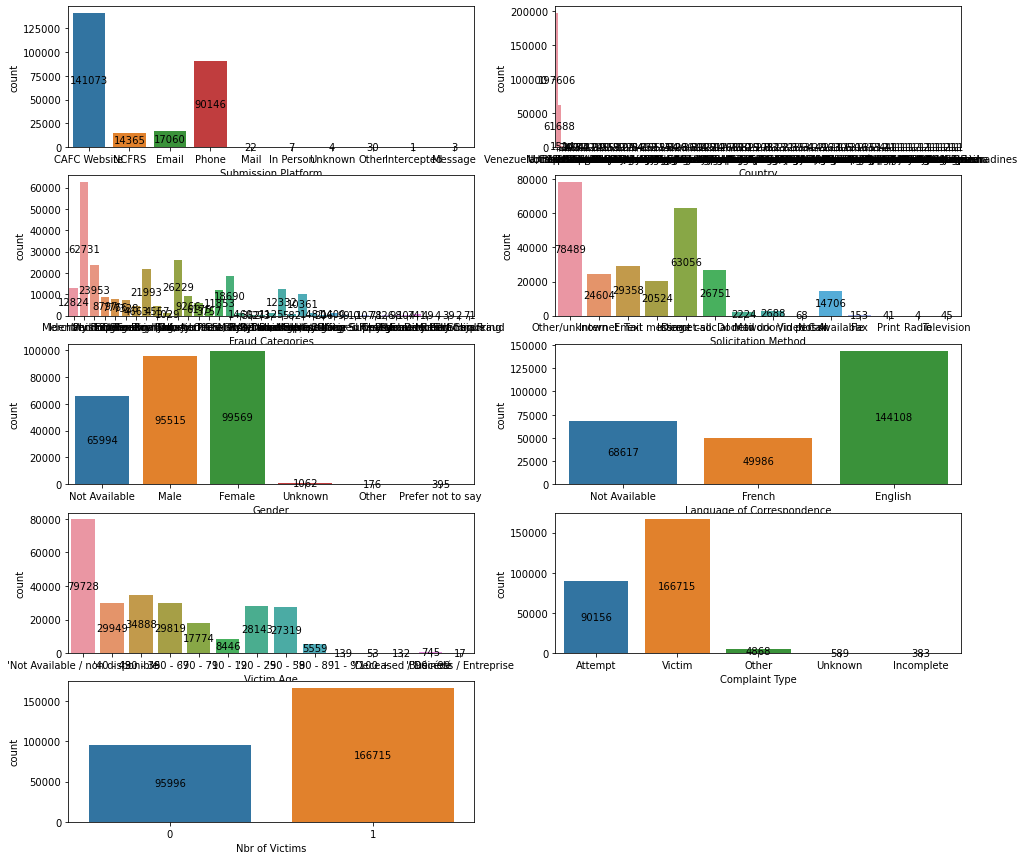

In [7]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(5, 2, idx+1)
    sns.countplot(x=data[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

We will use the information from these graphes to clean the data.

## 3. Data Cleaning
There are no null values, but many entries are labeled as 'Not available,' 'Not specified,' or 'Unknown.' Here's what we've observed after reviewing the columns:

<b>Submission Platform</b> indicates where the complaint was submitted. 'Mail', 'In Person', 'Other', 'Intercepted', 'Unknown' and 'Message' only have few instances, we can merge then under 'Other'.

<b>Country</b> and <b>Fraud Categories</b> can be left as is.

<b>Solicitation Method</b> is crucial for identifying fraud; however, 14706 entries are labeled as 'Not Available' out of 262710 data points. Dropping rows with unavailable data in this column seems acceptable.

<b>Gender</b>, <b>Language of Correspondence</b> and <b>Victim Age</b> have missing values. which shouldn't significantly impact the analysis.

I propose filtering the data to drop rows with more than 3 columns containing missing values.

In [8]:
data = data[data['Solicitation Method'] != 'Not Available']

Let's drop entries where <b>Gender</b>, <b>Language of Correspondence</b> and <b>Victim Age</b> are missing simultaneously. The we can rename some values.

In [9]:
indexes = data[(data["Gender"] == "Not Available") & 
                    (data["Language of Correspondence"] == "Not Available") & 
                    (data["Victim Age"] == "'Not Available / non disponible")].index

data_fraud = data.drop(indexes)
data_fraud.reset_index(drop=True, inplace=True)
data_fraud.head(3)

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Nbr of Victims,Money_Loss
0,CAFC Website,Canada,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,$0.00
1,CAFC Website,Canada,Phishing,Email,Male,English,'30 - 39,Victim,1,$0.00
2,CAFC Website,Canada,Merchandise,Other/unknown,Male,Not Available,'60 - 69,Victim,1,$222.73


Let's rename values.

In [10]:
data_fraud['Submission Platform'].replace(['Mail', 'In Person', 'Unknown', 'Message'], 'Other', inplace=True)
data_fraud['Gender'].replace('Not Available', 'Unknown', inplace=True)
data_fraud['Language of Correspondence'].replace('Not Available', 'Not specified', inplace=True)
data_fraud['Victim Age'].replace(["'Not Available / non disponible", 
                                  "'Deceased / Décédé","'Business / Entreprise"],
                                 ["Unknown", "Deceased","Business"], inplace=True)
data_fraud['Complaint Type'].replace(['Incomplete', 'Unknown'], 'Other', inplace=True)

When we take a look at the country column, some of the countries listed have value counts of 1. Since Canada and United States have the high counts, we can goup the remaining countries under the label 'Other Country'. 'Not Specified' can stay as is.

In [11]:
# This can be uncommented to see all value counts in Country columns
#pd.set_option('display.max_rows', None)
print(data_fraud['Country'].value_counts())
#pd.reset_option('display.max_rows')

Canada                             185815
Not Specified                        8512
United States                        1227
India                                 163
United Kingdom                         97
                                    ...  
Zambia                                  1
Saint Kitts and Nevis                   1
Macao                                   1
Mali                                    1
Bolivia, Plurinational State of         1
Name: Country, Length: 142, dtype: int64


In [12]:
names = []
for index, name in enumerate(data_fraud['Country'].value_counts().index.tolist()):
    if data_fraud['Country'].value_counts()[index] < 200:
        names.append(name)
        
data_fraud['Country'].replace(names, 'Other Country', inplace=True)
print(data_fraud['Country'].value_counts())

Canada           185815
Not Specified      8512
Other Country      1540
United States      1227
Name: Country, dtype: int64


When we take a look at Submission Platform and Country, they look much better.

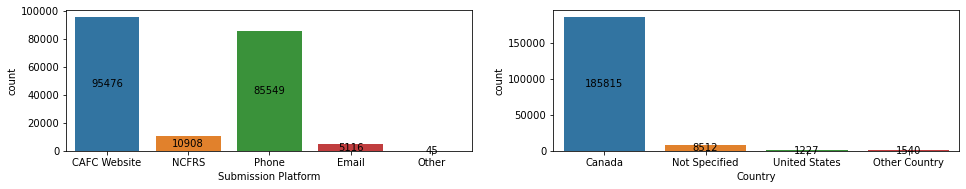

In [13]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(data_fraud.columns[:2]):
    ax = plt.subplot(5, 2, idx+1)
    sns.countplot(x=data_fraud[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

## 4. Target variable
We are predicting if money is lost by the victim during a fraudulent activity or not. The <b>Money_Loss</b> column is of interest here. Let's set instances where there is no monetary loss to 0 and those with loss of money to 1.

In [14]:
data_fraud['Money_Loss'] = data_fraud['Money_Loss'].apply(lambda x: 0 if x=="$0.00" else 1)

In [15]:
data_fraud.head()

,Submission Platform,Country,Fraud Categories,Solicitation Method,Gender,Language of Correspondence,Victim Age,Complaint Type,Nbr of Victims,Money_Loss
0,CAFC Website,Canada,Identity Fraud,Other/unknown,Male,French,'40 - 49,Victim,1,0
1,CAFC Website,Canada,Phishing,Email,Male,English,'30 - 39,Victim,1,0
2,CAFC Website,Canada,Merchandise,Other/unknown,Male,Not specified,'60 - 69,Victim,1,1
3,CAFC Website,Canada,Phishing,Text message,Male,English,'30 - 39,Attempt,0,0
4,CAFC Website,Canada,Identity Fraud,Other/unknown,Female,English,'70 - 79,Victim,1,0


## 5. Saving the cleaned data

We save the data in a csv file to be used for to build the [model](https://github.com/DorisKJ/Fraud_Detection/blob/main/fraud_detection_prediction.ipynb)

In [17]:
data_fraud.to_csv("fraud_reporting_data.csv")